## Importing libraries

In [51]:
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import shutil
import random as rn
from tqdm import tqdm
from tensorflow.keras.models import Sequential
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import torch

# Fetching dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
data_dir = '/content/drive/MyDrive/flowers'

In [7]:
classes = os.listdir(data_dir)
print(classes)

['rose', 'dandelion', 'tulip', 'daisy', 'sunflower']


In [12]:
batch_size = 32
img_height = 150
img_width = 150

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4343 files belonging to 5 classes.
Using 3475 files for training.


In [13]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4343 files belonging to 5 classes.
Using 868 files for validation.


In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 150, 150, 3)
(32,)


 **Detecting missing data and corrupt**

In [17]:
missing_count = 0
corrupt_count = 0

for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            try:
                img = Image.open(img_path)
            except (OSError, IOError):
                print(f"Error opening image: {img_path}")
                if not os.path.exists(img_path):
                    missing_count += 1
                else:
                    corrupt_count += 1

print(f"Total missing images: {missing_count}")
print(f"Total corrupted images: {corrupt_count}")

Total missing images: 0
Total corrupted images: 0


## Visualization

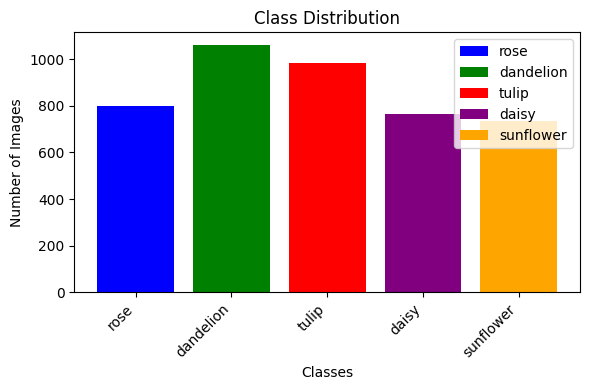

In [18]:
class_counts = {class_name: 0 for class_name in classes}
for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        image_count = len(os.listdir(class_dir))
        class_counts[class_name] = image_count
bar_colors = ['blue', 'green', 'red', 'purple', 'orange']
plt.figure(figsize=(6, 4))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=bar_colors)
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=45, ha='right')

plt.legend(bars, class_counts.keys())
plt.tight_layout()
plt.show()

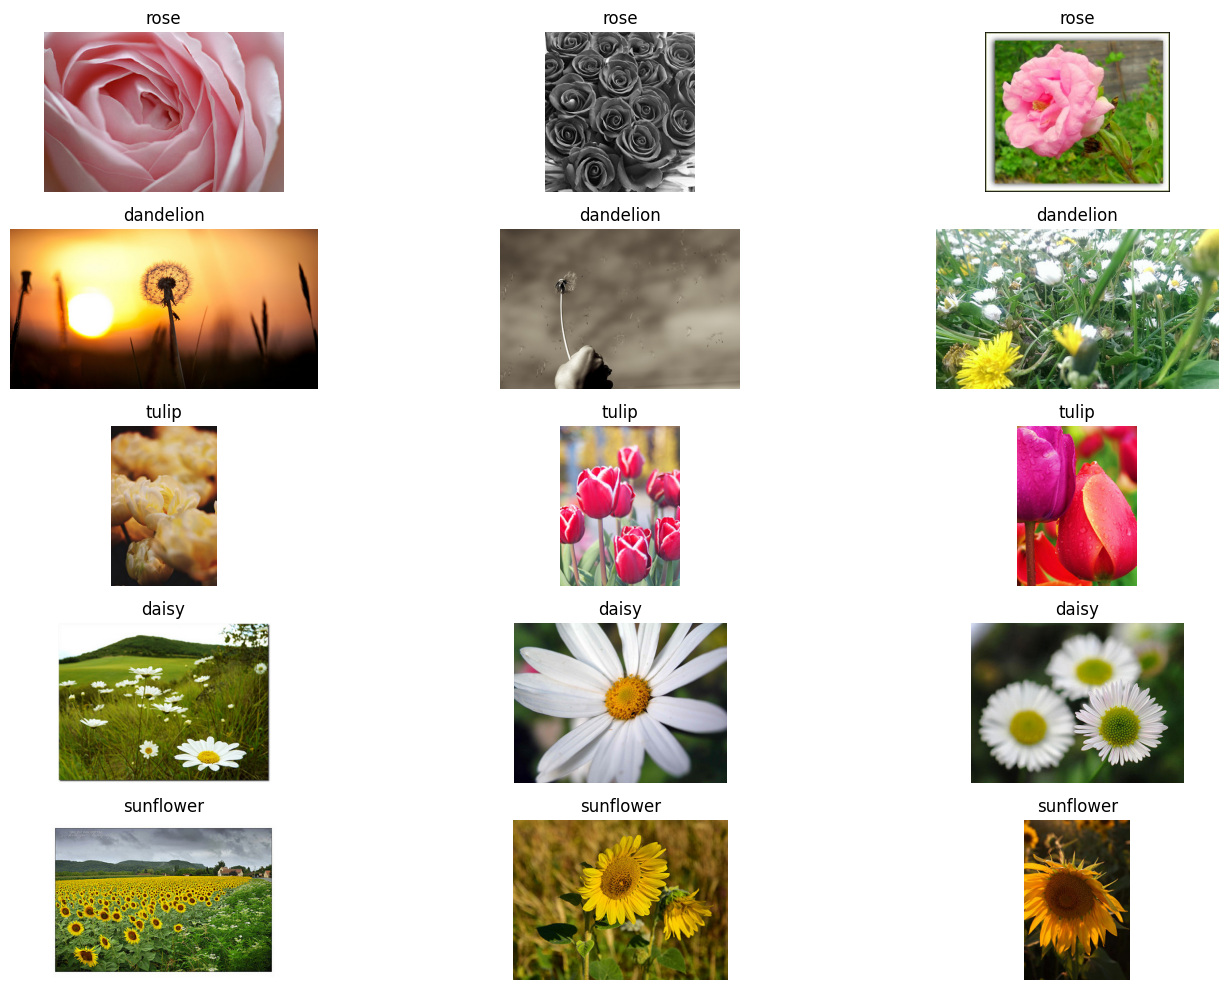

In [21]:
num_samples_per_class = 3

image_paths_by_class = {class_name: [] for class_name in classes}

for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        image_names = os.listdir(class_dir)
        image_paths_by_class[class_name] = [
            os.path.join(class_dir, img_name) for img_name in image_names
        ]

fig, axes = plt.subplots(len(classes), num_samples_per_class, figsize=(15, 10))

for idx, (class_name, image_paths) in enumerate(image_paths_by_class.items()):
    random_image_paths = random.sample(image_paths, num_samples_per_class)
    for col, img_path in enumerate(random_image_paths):
        img = Image.open(img_path)
        axes[idx, col].imshow(img)
        axes[idx, col].set_title(class_name)
        axes[idx, col].axis('off')

plt.tight_layout()
plt.show()

## Model architecture

In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [24]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [25]:
num_classes = 5
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# Training

In [27]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
109/109 [==============================] - 113s 1s/step - loss: 1.2593 - accuracy: 0.4636 - val_loss: 1.0457 - val_accuracy: 0.5818
Epoch 2/10
109/109 [==============================] - 109s 999ms/step - loss: 0.9571 - accuracy: 0.6199 - val_loss: 0.9917 - val_accuracy: 0.6037
Epoch 3/10
109/109 [==============================] - 101s 925ms/step - loss: 0.8469 - accuracy: 0.6702 - val_loss: 0.8924 - val_accuracy: 0.6486
Epoch 4/10
109/109 [==============================] - 103s 945ms/step - loss: 0.7569 - accuracy: 0.6996 - val_loss: 0.8579 - val_accuracy: 0.6624
Epoch 5/10
109/109 [==============================] - 105s 960ms/step - loss: 0.6808 - accuracy: 0.7344 - val_loss: 0.8261 - val_accuracy: 0.6924
Epoch 6/10
109/109 [==============================] - 104s 951ms/step - loss: 0.5602 - accuracy: 0.7871 - val_loss: 0.7840 - val_accuracy: 0.7189
Epoch 7/10
109/109 [==============================] - 105s 963ms/step - loss: 0.4176 - accuracy: 0.8420 - val_loss: 0.8644 - va

Epochs vs Accuracy Graph

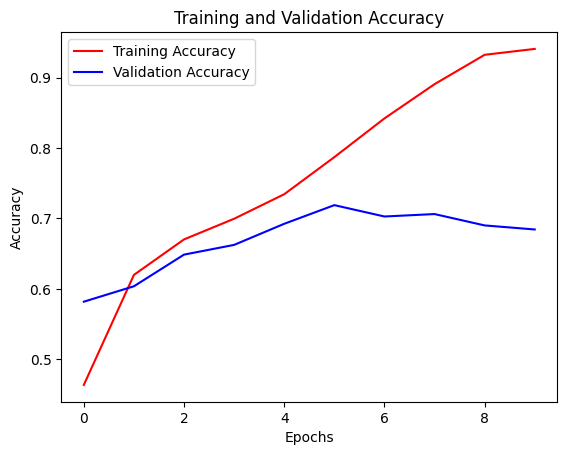

In [28]:
epochs = range(10)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Validation accuracy has halted and even decreased after few epochs, hence it indicates **Overfitting**

Using **Data augmentaion** and **Dropout** to minimize the overfitting

In [44]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [45]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [46]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [47]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
109/109 [==============================] - 122s 1s/step - loss: 1.2448 - accuracy: 0.4696 - val_loss: 1.1544 - val_accuracy: 0.5484
Epoch 2/20
109/109 [==============================] - 116s 1s/step - loss: 1.0187 - accuracy: 0.5902 - val_loss: 1.0205 - val_accuracy: 0.5749
Epoch 3/20
109/109 [==============================] - 115s 1s/step - loss: 0.9443 - accuracy: 0.6250 - val_loss: 0.9212 - val_accuracy: 0.6498
Epoch 4/20
109/109 [==============================] - 115s 1s/step - loss: 0.8837 - accuracy: 0.6518 - val_loss: 0.8369 - val_accuracy: 0.6901
Epoch 5/20
109/109 [==============================] - 115s 1s/step - loss: 0.8206 - accuracy: 0.6806 - val_loss: 0.9178 - val_accuracy: 0.6567
Epoch 6/20
109/109 [==============================] - 115s 1s/step - loss: 0.8187 - accuracy: 0.6812 - val_loss: 0.8478 - val_accuracy: 0.6901
Epoch 7/20
109/109 [==============================] - 117s 1s/step - loss: 0.7747 - accuracy: 0.7010 - val_loss: 0.8937 - val_accuracy: 0.6590

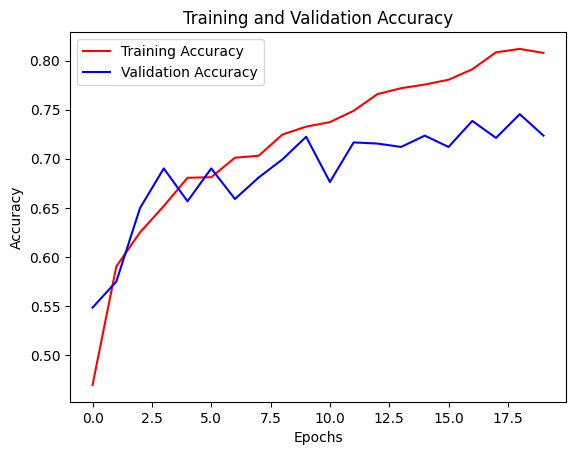

In [49]:
epochs = range(20)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()